In [1]:
import os
import random
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms.functional as func

In [2]:
def generate_d4_augmentations(image):
    """
    Given a grayscale image tensor of shape (1, 224, 224),
    return a list of 8 image tensors with D4 augmentations:
    [original, rot90, rot180, rot270, hflip, vflip, diag1_flip, diag2_flip]
    """
    assert image.shape == (1, 224, 224), "Image must be of shape (1, 224, 224)"

    # Generate augmentations
    original = image
    rot90 = func.rotate(image, angle=90)
    rot180 = func.rotate(image, angle=180)
    rot270 = func.rotate(image, angle=270)
    hflip = func.hflip(image)
    vflip = func.vflip(image)

    diag1_flip = torch.transpose(image, 1, 2)  # top-left to bottom-right
    diag2_flip = torch.flip(torch.transpose(image, 1, 2), dims=[2])  # top-right to bottom-left

    return [original, rot90, rot180, rot270, hflip, vflip, diag1_flip, diag2_flip]


def apply_affine_transform(image_tensor,
                           max_rotation=15,
                           max_translation=0.05,
                           scale_range=(0.95, 1.05),
                           max_shear=5):
    """
    Apply a small random affine transformation to a grayscale image tensor.

    Args:
        image_tensor (torch.Tensor): Tensor of shape (1, H, W) with values in [0, 1]
        max_rotation (float): Max degrees for rotation (±)
        max_translation (float): Max proportion of width/height to translate
        scale_range (tuple): Min and max scale factors
        max_shear (float): Max shear angle in degrees (±)

    Returns:
        torch.Tensor: Transformed image tensor (1, H, W)
    """
    _, h, w = image_tensor.shape

    angle = random.uniform(-max_rotation, max_rotation)
    translate_x = int(max_translation * w * random.uniform(-1, 1))
    translate_y = int(max_translation * h * random.uniform(-1, 1))
    scale = random.uniform(*scale_range)
    shear = random.uniform(-max_shear, max_shear)
    mean = torch.mean(image_tensor)

    transformed = func.affine(
        image_tensor,
        angle=angle,
        translate=[translate_x, translate_y],
        scale=scale,
        shear=shear,
        interpolation=func.InterpolationMode.BILINEAR,
        fill=mean.item()
    )

    return transformed


def get_augmented_images(image_tensor: torch.Tensor, augmentation="low") -> list[torch.Tensor]:
    augmented_images = generate_d4_augmentations(image_tensor)

    if augmentation == "low":
        return random.sample(augmented_images, k=4)

    elif augmentation == "medium":
        return augmented_images

    transformed = [apply_affine_transform(i) for i in augmented_images]
    return augmented_images + transformed



In [3]:
class SkinCancerDataset(Dataset):
    def __init__(self, transform, path, train=True):
        self.samples = []
        self.num_samples = {i: 0 for i in range(7)}

        for file_path in glob(os.path.join(path, "*.jpg")):
            file_name = os.path.basename(file_path)
            class_id = int(file_name.split("_")[0])

            image = read_image(file_path).float()
            image = transform(image)

            if not train:
                self.samples.append((image, class_id - 1))
                self.num_samples[class_id - 1] += 1
                continue

            if class_id in [3, 5]:  # 1 image -> 4 images
                images = get_augmented_images(image, augmentation="low")
            elif class_id in [1, 2]:  # 1 image -> 8 images
                images = get_augmented_images(image, augmentation="medium")
            elif class_id in [4, 7]:  # 1 image -> 16 images
                images = get_augmented_images(image, augmentation="high")
            else:
                images = [image]

            for i in images:
                if class_id == 6 and self.num_samples[class_id - 1] < 1000:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1
                elif class_id != 6:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tensor, label = self.samples[idx]
        return tensor, label


In [4]:
def get_weighted_sampler(labels):
    """
    Creates a WeightedRandomSampler to oversample minority classes.

    Args:
        labels (List[int] or Tensor): List of class labels for each sample in dataset.

    Returns:
        WeightedRandomSampler: Sampler to use in DataLoader.
    """
    labels = torch.tensor(labels)
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(labels),  # or more for aggressive balancing
        replacement=True
    )
    return sampler


In [35]:
folder_path = "train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_set = SkinCancerDataset(transform, folder_path, train=False)
all_labels = [label for _, label in train_set]
sampler = get_weighted_sampler(all_labels)

print(len(train_set))
print(train_set.num_samples)
train_loader = DataLoader(train_set, batch_size=16, sampler=sampler)
val_set = SkinCancerDataset(transform, "val", train=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

3000
{0: 112, 1: 148, 2: 343, 3: 36, 4: 253, 5: 2073, 6: 35}


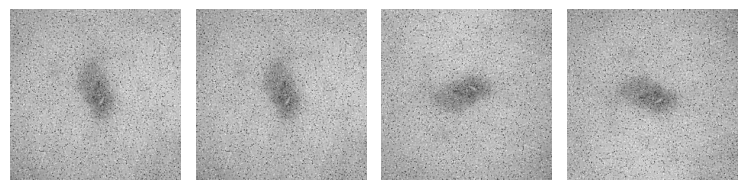

In [10]:
import matplotlib.pyplot as plt

image_1 = train_set.__getitem__(1000)[0]
images = torch.stack(get_augmented_images(image_1, augmentation="low"))
images = images.view(len(images), 224, 224).detach().numpy()

rows = (len(images) + 8 - 1) // 8
plt.figure(figsize=(15, 10))
for i, img in enumerate(images):
    plt.subplot(rows, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

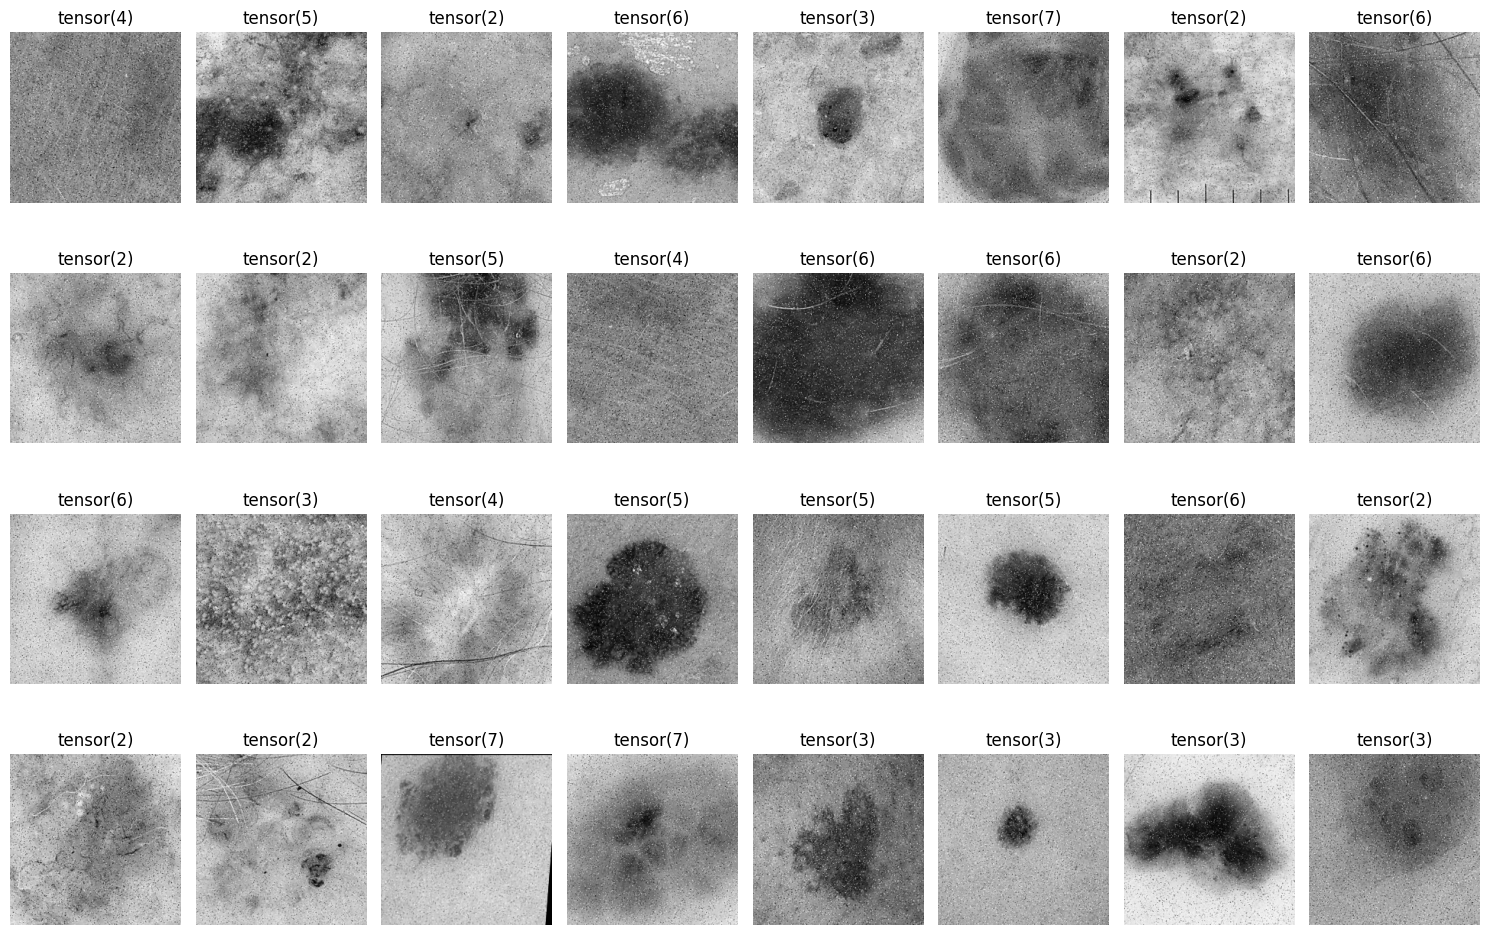

In [7]:
images, labels = next(iter(train_loader))
images = images.view(32, 224, 224).detach().numpy()

rows = (len(images) + 8 - 1) // 8
plt.figure(figsize=(15, 10))
for i, img in enumerate(images):
    plt.subplot(rows, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(str(labels[i] + 1))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [100]:
# # Depth-wise separable conv block
# class DepthwiseSeparableConv(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
#                                    stride=stride, padding=1, groups=in_channels, bias=False)
#         self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
#                                    stride=1, padding=0, bias=False)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#
#     def forward(self, x):
#         x = self.depthwise(x)
#         x = self.pointwise(x)
#         x = self.bn(x)
#         return self.relu(x)
#
#
# class MobileNetV1Gray(nn.Module):
#     def __init__(self, num_classes=7):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),  # for grayscale
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#
#             DepthwiseSeparableConv(32, 64),
#             DepthwiseSeparableConv(64, 128, stride=2),
#             DepthwiseSeparableConv(128, 128),
#             DepthwiseSeparableConv(128, 256, stride=2),
#             DepthwiseSeparableConv(256, 256),
#             DepthwiseSeparableConv(256, 512, stride=2),
#
#             *[DepthwiseSeparableConv(512, 512) for _ in range(5)],
#
#             DepthwiseSeparableConv(512, 1024, stride=2),
#             DepthwiseSeparableConv(1024, 1024),
#
#             nn.AdaptiveAvgPool2d(1)
#         )
#         self.fc = nn.Linear(1024, num_classes)
#
#     def forward(self, x):
#         x = self.model(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)


In [157]:
# import torch.nn.functional as F
#
# # Hard-swish activation (used in MobileNetV3)
# class HSwish(nn.Module):
#     def forward(self, x):
#         return x * F.hardtanh(x + 3, 0., 6.) / 6
#
# # Squeeze-and-Excitation block
# class SEBlock(nn.Module):
#     def __init__(self, in_channels, se_ratio=0.25):
#         super().__init__()
#         reduced_channels = int(in_channels * se_ratio)
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(in_channels, reduced_channels, 1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(reduced_channels, in_channels, 1),
#             nn.Sigmoid()
#         )
#
#     def forward(self, x):
#         return x * self.se(x)
#
# # MobileNetV3 Block (bottleneck with optional SE and h-swish)
# class MobileBottleneck(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, expansion, use_se, activation):
#         super().__init__()
#         self.stride = stride
#         mid_channels = int(in_channels * expansion)
#         self.use_residual = (in_channels == out_channels and stride == 1)
#
#         self.block = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, 1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             activation(),
#
#             nn.Conv2d(mid_channels, mid_channels, kernel_size, stride, kernel_size//2, groups=mid_channels, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             SEBlock(mid_channels) if use_se else nn.Identity(),
#             activation(),
#
#             nn.Conv2d(mid_channels, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )
#
#     def forward(self, x):
#         out = self.block(x)
#         if self.use_residual:
#             out += x
#         return out


In [158]:
# class MobileNetV3Large(nn.Module):
#     def __init__(self, num_classes=2):
#         super().__init__()
#
#         act = lambda: nn.ReLU(inplace=True)
#         hswish = lambda: HSwish()
#
#         self.stem = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1, bias=False),  # Grayscale input
#             nn.BatchNorm2d(16),
#             hswish()
#         )
#
#         self.blocks = nn.Sequential(
#             MobileBottleneck(16, 16, 3, 1, 1, False, act),
#             MobileBottleneck(16, 24, 3, 2, 4, False, act),
#             MobileBottleneck(24, 24, 3, 1, 3, False, act),
#             MobileBottleneck(24, 40, 5, 2, 3, True, act),
#             MobileBottleneck(40, 40, 5, 1, 3, True, act),
#             MobileBottleneck(40, 40, 5, 1, 3, True, act),
#             MobileBottleneck(40, 80, 3, 2, 6, False, hswish),
#             MobileBottleneck(80, 80, 3, 1, 2.5, False, hswish),
#             MobileBottleneck(80, 80, 3, 1, 2.3, False, hswish),
#             MobileBottleneck(80, 80, 3, 1, 2.3, False, hswish),
#             MobileBottleneck(80, 112, 3, 1, 6, True, hswish),
#             MobileBottleneck(112, 112, 3, 1, 6, True, hswish),
#             MobileBottleneck(112, 160, 5, 2, 6, True, hswish),
#             MobileBottleneck(160, 160, 5, 1, 6, True, hswish),
#             MobileBottleneck(160, 160, 5, 1, 6, True, hswish),
#         )
#
#         self.head = nn.Sequential(
#             nn.Conv2d(160, 960, 1, bias=False),
#             nn.BatchNorm2d(960),
#             hswish(),
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(960, 1280, 1),
#             hswish(),
#             nn.Flatten(),
#             nn.Linear(1280, num_classes)
#         )
#
#     def forward(self, x):
#         x = self.stem(x)
#         x = self.blocks(x)
#         x = self.head(x)
#         return x


In [28]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

class MobileNetV3Gray(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Load pretrained MobileNetV3-Large
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

        # Modify the first conv layer to accept 1-channel input instead of 3
        self.model.features[0][0] = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        # for param in self.model.features.parameters():
        #     param.requires_grad = False

        # Modify the classifier to output the correct number of classes
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [16]:
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
#
# class MobileNetV2Gray(nn.Module):
#     def __init__(self, num_classes=7):
#         super().__init__()
#
#         # Load pretrained MobileNetV2
#         self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
#
#         # Modify the first conv layer to accept 1-channel input (grayscale)
#         self.model.features[0][0] = nn.Conv2d(
#             in_channels=1,
#             out_channels=32,
#             kernel_size=3,
#             stride=2,
#             padding=1,
#             bias=False
#         )
#
#         # Modify the classifier for your number of classes
#         in_features = self.model.classifier[1].in_features
#         self.model.classifier[1] = nn.Linear(in_features, num_classes)
#
#     def forward(self, x):
#         return self.model(x)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Gray(num_classes=7).to(device)
print(model)

MobileNetV3Gray(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivat

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

In [44]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
#
# all_labels = [label for _, label in train_set]
#
# classes = np.unique(all_labels)
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [45]:
from tqdm import tqdm

losses = []
val_accuracies = []
for epoch in range(num_epochs):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss = epoch_loss / len(train_loader)
        loop.set_postfix(running_loss=running_loss)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += torch.eq(predicted, labels).sum().item()

    val_accuracies.append(correct / total)
    losses.append(epoch_loss / len(train_loader))

    scheduler.step()


Epoch 10/10: 100%|██████████| 188/188 [00:42<00:00,  4.42it/s, running_loss=0.0985]


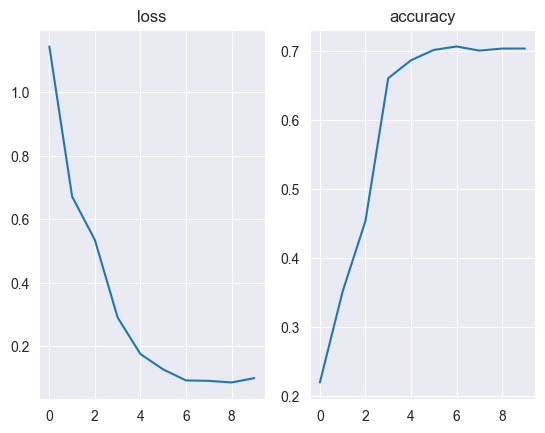

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].plot(losses)
axes[0].set_title('loss')
axes[1].plot(val_accuracies)
axes[1].set_title('accuracy')
plt.show()

In [48]:
torch.save(model.state_dict(), "model_1.pth")

In [47]:
model.eval()
with torch.no_grad():
    correct = [0] * 7
    total = [0] * 7

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        for true, pred in zip(labels, predicted):
            total[true] += 1
            correct[true] += int(true == pred)

    print(f"Overall accuracy: {100 * sum(correct) / sum(total):.2f}")
    print("Per class accuracy:")
    for i, (correct, total) in enumerate(zip(correct, total)):
        print(f"Class {i + 1}: {100 * correct / total:.2f}%")

Overall accuracy: 70.30
Per class accuracy:
Class 1: 36.11%
Class 2: 28.33%
Class 3: 57.84%
Class 4: 6.67%
Class 5: 32.99%
Class 6: 86.72%
Class 7: 0.00%
